In [2]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, root_mean_squared_error
import seaborn as sns
sns.set_style("darkgrid")

In [3]:
X_training = pl.read_excel("ftalany.xlsx", sheet_name="X_train")
X_test = pl.read_excel("ftalany.xlsx", sheet_name="X_test")
Y_training = pl.read_excel("ftalany.xlsx", sheet_name="y_train")
Y_test = pl.read_excel("ftalany.xlsx", sheet_name="y_test")

In [4]:
X_training = X_training.rename({"qc-": "qc"})

Ze wzgledu na mala liczbe probek, uwazam ze odpowiednia wartoscia $k$ bedzie $23$ co oznacza ze walidacja krzyzowa zostanie wykonana dla kazdego obiektu osobno.

In [5]:
cv = KFold(n_splits=23, shuffle=True, random_state=1)

In [6]:
rmse_cv_scores = []
cv = KFold(n_splits = 23, shuffle = True, random_state = 1)

for k in list(range(2, 23)) :
    KNN_model = KNeighborsRegressor(n_neighbors = k, metric ='euclidean')
    mse_scores = cross_val_score(KNN_model, X_training, Y_training, cv = cv, scoring = 'neg_mean_squared_error')
    rmse = np.sqrt(-mse_scores.mean())
    rmse_cv_scores.append(rmse)
    
rmse_cv_scores

[np.float64(0.18648818327175587),
 np.float64(0.18660088553672996),
 np.float64(0.202560259083026),
 np.float64(0.21237858952106387),
 np.float64(0.21890618661574496),
 np.float64(0.22425142729576575),
 np.float64(0.24577422211061123),
 np.float64(0.25270702631443576),
 np.float64(0.2645061948317049),
 np.float64(0.27028632036535605),
 np.float64(0.2948345067606768),
 np.float64(0.314150710068401),
 np.float64(0.3372127347674644),
 np.float64(0.35867548132318083),
 np.float64(0.37734687030170866),
 np.float64(0.39196887925164453),
 np.float64(0.40270897864689265),
 np.float64(0.4262756563588203),
 np.float64(0.44730450857475645),
 np.float64(0.47805717062304104),
 np.float64(0.5062292189796638)]

Text(0, 0.5, 'RMSE')

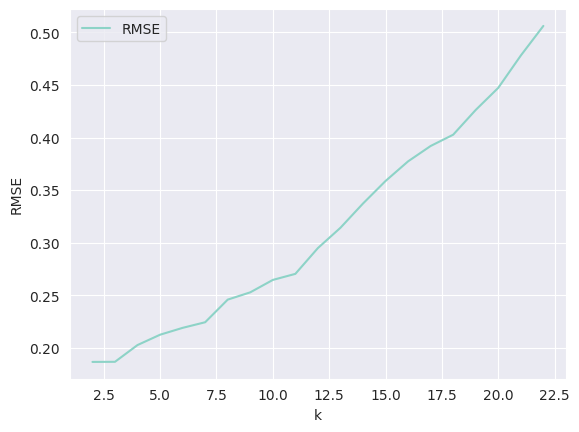

In [7]:
plt.plot(range(2,23), rmse_cv_scores, label='RMSE')
plt.legend()
plt.xlabel("k")
plt.ylabel("RMSE")

Wybieram $k=3$ ze wzgledu na optymalne wartosci $RMSE$, $Q^2_{ext}$ oraz nieparzystosc.

In [8]:
KNN_model = KNeighborsRegressor(n_neighbors=3)

In [9]:
KNN_model_fitted = KNN_model.fit(X_training, Y_training)

In [10]:
y_pred_training = KNN_model_fitted.predict(X_training)
y_pred_test = KNN_model_fitted.predict(X_test)

$R^2$

In [11]:
r2_score(y_pred_training.flatten(), Y_training)

0.9308795530186199

$RMSE_c$

In [12]:
root_mean_squared_error(y_pred_training.flatten(), Y_training)

0.12432545551450391

$Q^2_{ext}$

In [13]:
r2_score(y_pred_test.flatten(), Y_test)

0.8681824452818329

$RMSE_{ext}$

In [14]:
root_mean_squared_error(y_pred_test.flatten(), Y_test)

0.12996238772130267

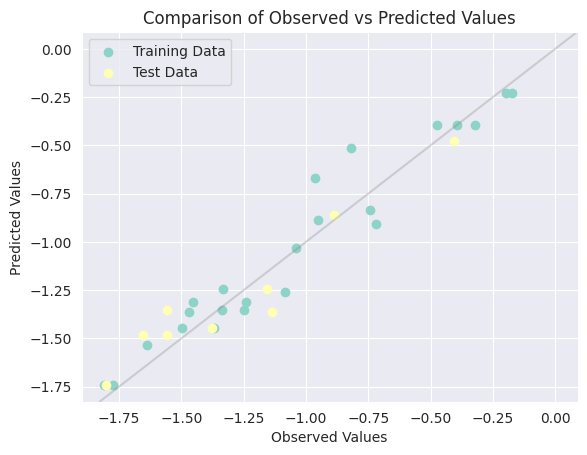

In [15]:
# Scatter plot of training and test predictions
plt.scatter(Y_training, y_pred_training, label="Training Data")
plt.scatter(Y_test, y_pred_test, label="Test Data")

# Add legend
plt.legend()

# Add a diagonal line for reference
plt.axline((0, 0), slope=1, color="grey", alpha=0.3)

# Add title and labels
plt.title("Comparison of Observed vs Predicted Values")
plt.xlabel("Observed Values")
plt.ylabel("Predicted Values")

# Show plot
plt.show()

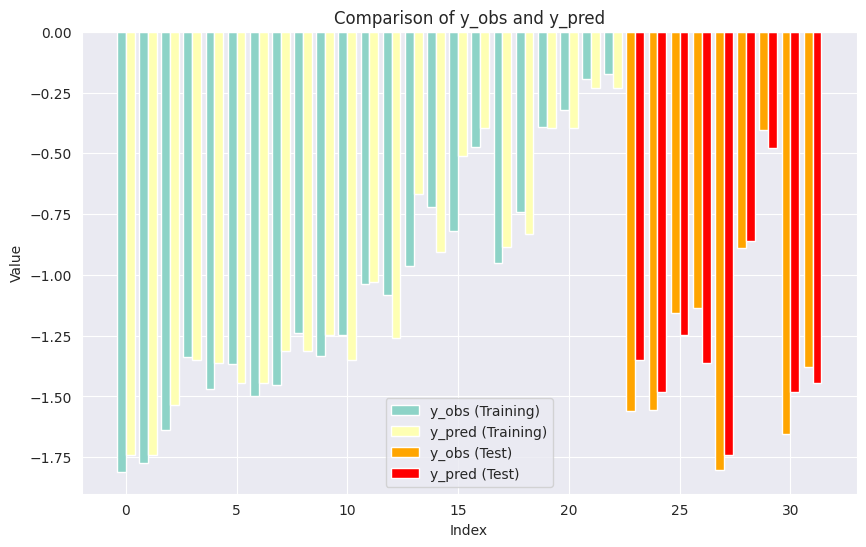

In [16]:
# Convert y_pred and y_obs to 1D arrays for easier plotting
y_pred_training_flat = y_pred_training.flatten()
y_obs_training_flat = Y_training.to_series().to_numpy()
y_pred_test_flat = y_pred_test.flatten()
y_obs_test_flat = Y_test.to_series().to_numpy()

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.4  # the width of the bars

# Plot y_obs and y_pred for training data side by side
ax.bar(np.arange(len(y_obs_training_flat)) - width/2, y_obs_training_flat, width, label='y_obs (Training)')
ax.bar(np.arange(len(y_obs_training_flat)) + width/2, y_pred_training_flat, width, label='y_pred (Training)')

# Plot y_obs and y_pred for test data side by side
ax.bar(np.arange(len(y_obs_training_flat), len(y_obs_training_flat) + len(y_obs_test_flat)) - width/2, y_obs_test_flat, width, label='y_obs (Test)', color='orange')
ax.bar(np.arange(len(y_obs_training_flat), len(y_obs_training_flat) + len(y_obs_test_flat)) + width/2, y_pred_test_flat, width, label='y_pred (Test)', color='red')

# Add labels and legend
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.set_title('Comparison of y_obs and y_pred')
ax.legend()

plt.show()

In [17]:
def KNN_model_metrics_comparision(weighted: bool) -> None:
    """
    Compare KNN model metrics using different distance metrics.

    This function trains a K-Nearest Neighbors (KNN) regression model using various distance metrics
    and evaluates the model's performance on both training and test datasets. It plots the following metrics:
    - R2 score for training data
    - Root Mean Squared Error (RMSE) for training data
    - Q2 score for test data
    - Root Mean Squared Error (RMSE) for test data
    - Difference between R2 and Q2 scores

    Parameters:
    weighted (bool): If True, use distance-weighted KNN. If False, use uniform weights.

    Returns:
    None
    """
    metrics = ("euclidean", "manhattan", "chebyshev", "canberra")
    colors = sns.color_palette("pastel", len(metrics))
    r2_values = []
    rmse_c_values = []
    q2_ext_values = []
    rmse_ext_values = []
    diff_r2_q2 = []

    for metric in metrics:
        if weighted:
            KNN_model = KNeighborsRegressor(n_neighbors=3, metric=metric, weights='distance')
        else:
            KNN_model = KNeighborsRegressor(n_neighbors=3, metric=metric)
        KNN_model_fitted = KNN_model.fit(X_training, Y_training)

        y_pred_training = KNN_model_fitted.predict(X_training)
        y_pred_test = KNN_model_fitted.predict(X_test)

        r2 = r2_score(y_pred_training.flatten(), Y_training)
        q2 = r2_score(y_pred_test.flatten(), Y_test)

        r2_values.append(r2)
        rmse_c_values.append(root_mean_squared_error(y_pred_training.flatten(), Y_training))
        q2_ext_values.append(q2)
        rmse_ext_values.append(root_mean_squared_error(y_pred_test.flatten(), Y_test))
        diff_r2_q2.append(r2 - q2)

    fig, axs = plt.subplots(3, 2, figsize=(12, 18))

    # Plot R2 for training data
    axs[0, 0].bar(metrics, r2_values, color=colors)
    axs[0, 0].set_title('R2 (Training)')
    axs[0, 0].set_ylabel('R2')

    # Plot RMSE for training data
    axs[0, 1].bar(metrics, rmse_c_values, color=colors)
    axs[0, 1].set_title('RMSE (Training)')
    axs[0, 1].set_ylabel('RMSE')

    # Plot Q2 for test data
    axs[1, 0].bar(metrics, q2_ext_values, color=colors)
    axs[1, 0].set_title('Q2 (Test)')
    axs[1, 0].set_ylabel('Q2')

    # Plot RMSE for test data
    axs[1, 1].bar(metrics, rmse_ext_values, color=colors)
    axs[1, 1].set_title('RMSE (Test)')
    axs[1, 1].set_ylabel('RMSE')

    # Plot difference between R2 and Q2
    axs[2, 0].bar(metrics, diff_r2_q2, color=colors)
    axs[2, 0].set_title('Difference between R2 and Q2')
    axs[2, 0].set_ylabel('R2 - Q2')

    # Hide the empty subplot
    axs[2, 1].axis('off')

    plt.tight_layout()
    plt.show()


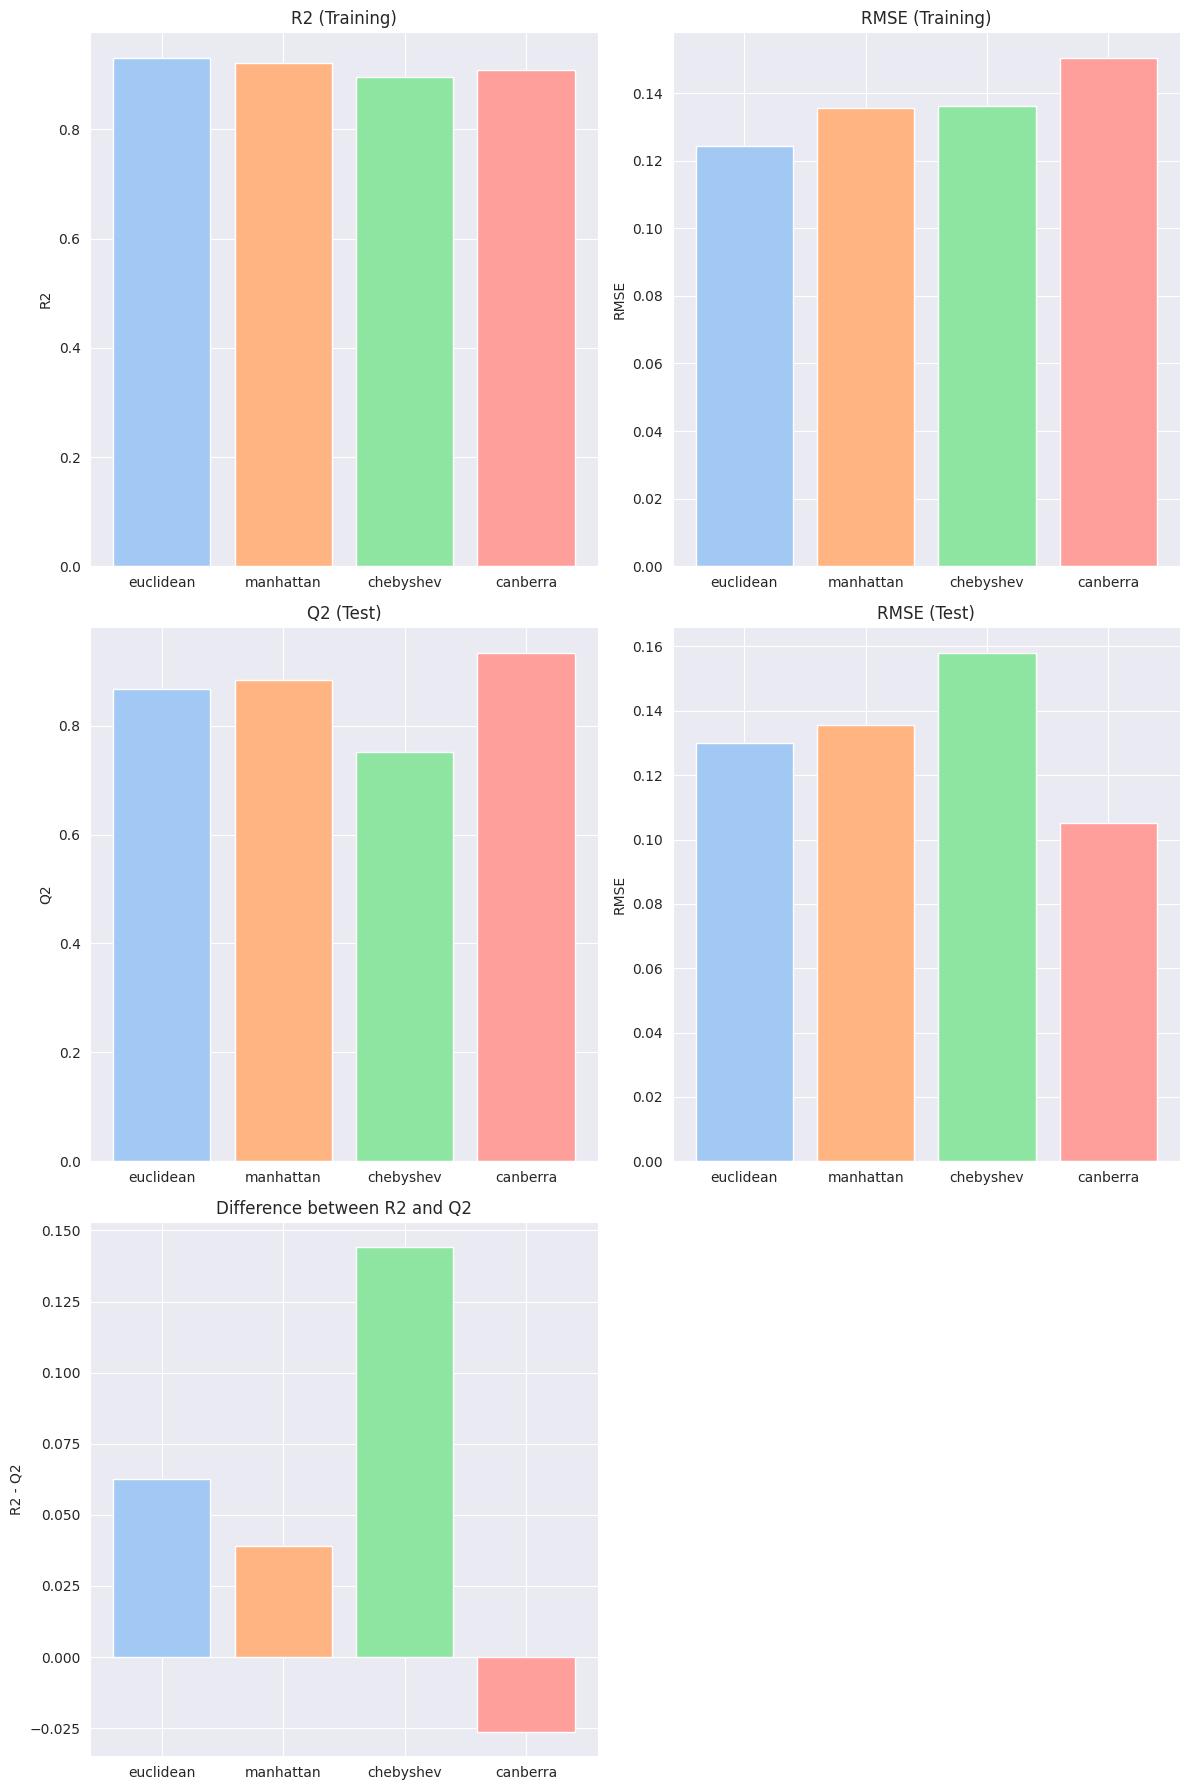

In [18]:
KNN_model_metrics_comparision(weighted=False)

In [19]:
KNN_model = KNeighborsRegressor(n_neighbors=3, weights='distance')
KNN_model_fitted = KNN_model.fit(X_training, Y_training)

y_pred_training = KNN_model_fitted.predict(X_training)
y_pred_test = KNN_model_fitted.predict(X_test)

$R^2$

In [20]:
r2_score(y_pred_training.flatten(), Y_training)

1.0

$RMSE_c$

In [21]:
root_mean_squared_error(y_pred_training.flatten(), Y_training)

0.0

$Q^2_{ext}$

In [22]:
r2_score(y_pred_test.flatten(), Y_test)

0.869534040707288

$RMSE_{ext}$

In [23]:
root_mean_squared_error(y_pred_test.flatten(), Y_test)

0.13277537302299516

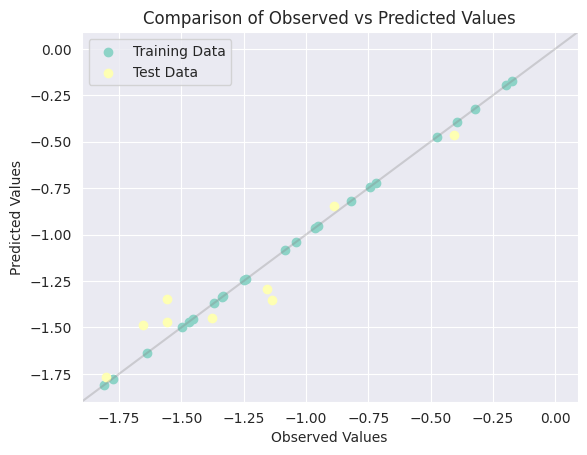

In [24]:
# Scatter plot of training and test predictions
plt.scatter(Y_training, y_pred_training, label="Training Data")
plt.scatter(Y_test, y_pred_test, label="Test Data")

# Add legend
plt.legend()

# Add a diagonal line for reference
plt.axline((0, 0), slope=1, color="grey", alpha=0.3)

# Add title and labels
plt.title("Comparison of Observed vs Predicted Values")
plt.xlabel("Observed Values")
plt.ylabel("Predicted Values")

# Show plot
plt.show()

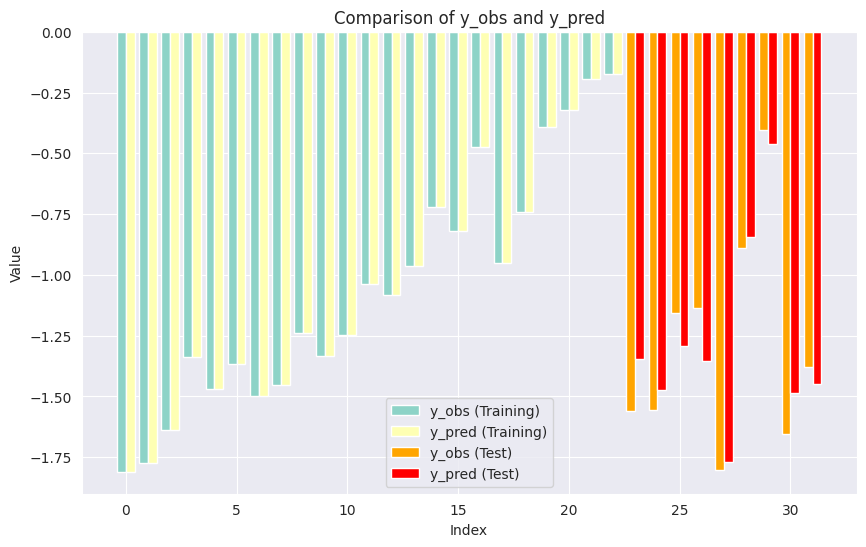

In [27]:
# Convert y_pred and y_obs to 1D arrays for easier plotting
y_pred_training_flat = y_pred_training.flatten()
y_obs_training_flat = Y_training.to_series().to_numpy()
y_pred_test_flat = y_pred_test.flatten()
y_obs_test_flat = Y_test.to_series().to_numpy()

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.4  # the width of the bars

# Plot y_obs and y_pred for training data side by side
ax.bar(np.arange(len(y_obs_training_flat)) - width/2, y_obs_training_flat, width, label='y_obs (Training)')
ax.bar(np.arange(len(y_obs_training_flat)) + width/2, y_pred_training_flat, width, label='y_pred (Training)')

# Plot y_obs and y_pred for test data side by side
ax.bar(np.arange(len(y_obs_training_flat), len(y_obs_training_flat) + len(y_obs_test_flat)) - width/2, y_obs_test_flat, width, label='y_obs (Test)', color='orange')
ax.bar(np.arange(len(y_obs_training_flat), len(y_obs_training_flat) + len(y_obs_test_flat)) + width/2, y_pred_test_flat, width, label='y_pred (Test)', color='red')

# Add labels and legend
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.set_title('Comparison of y_obs and y_pred')
ax.legend()

plt.show()

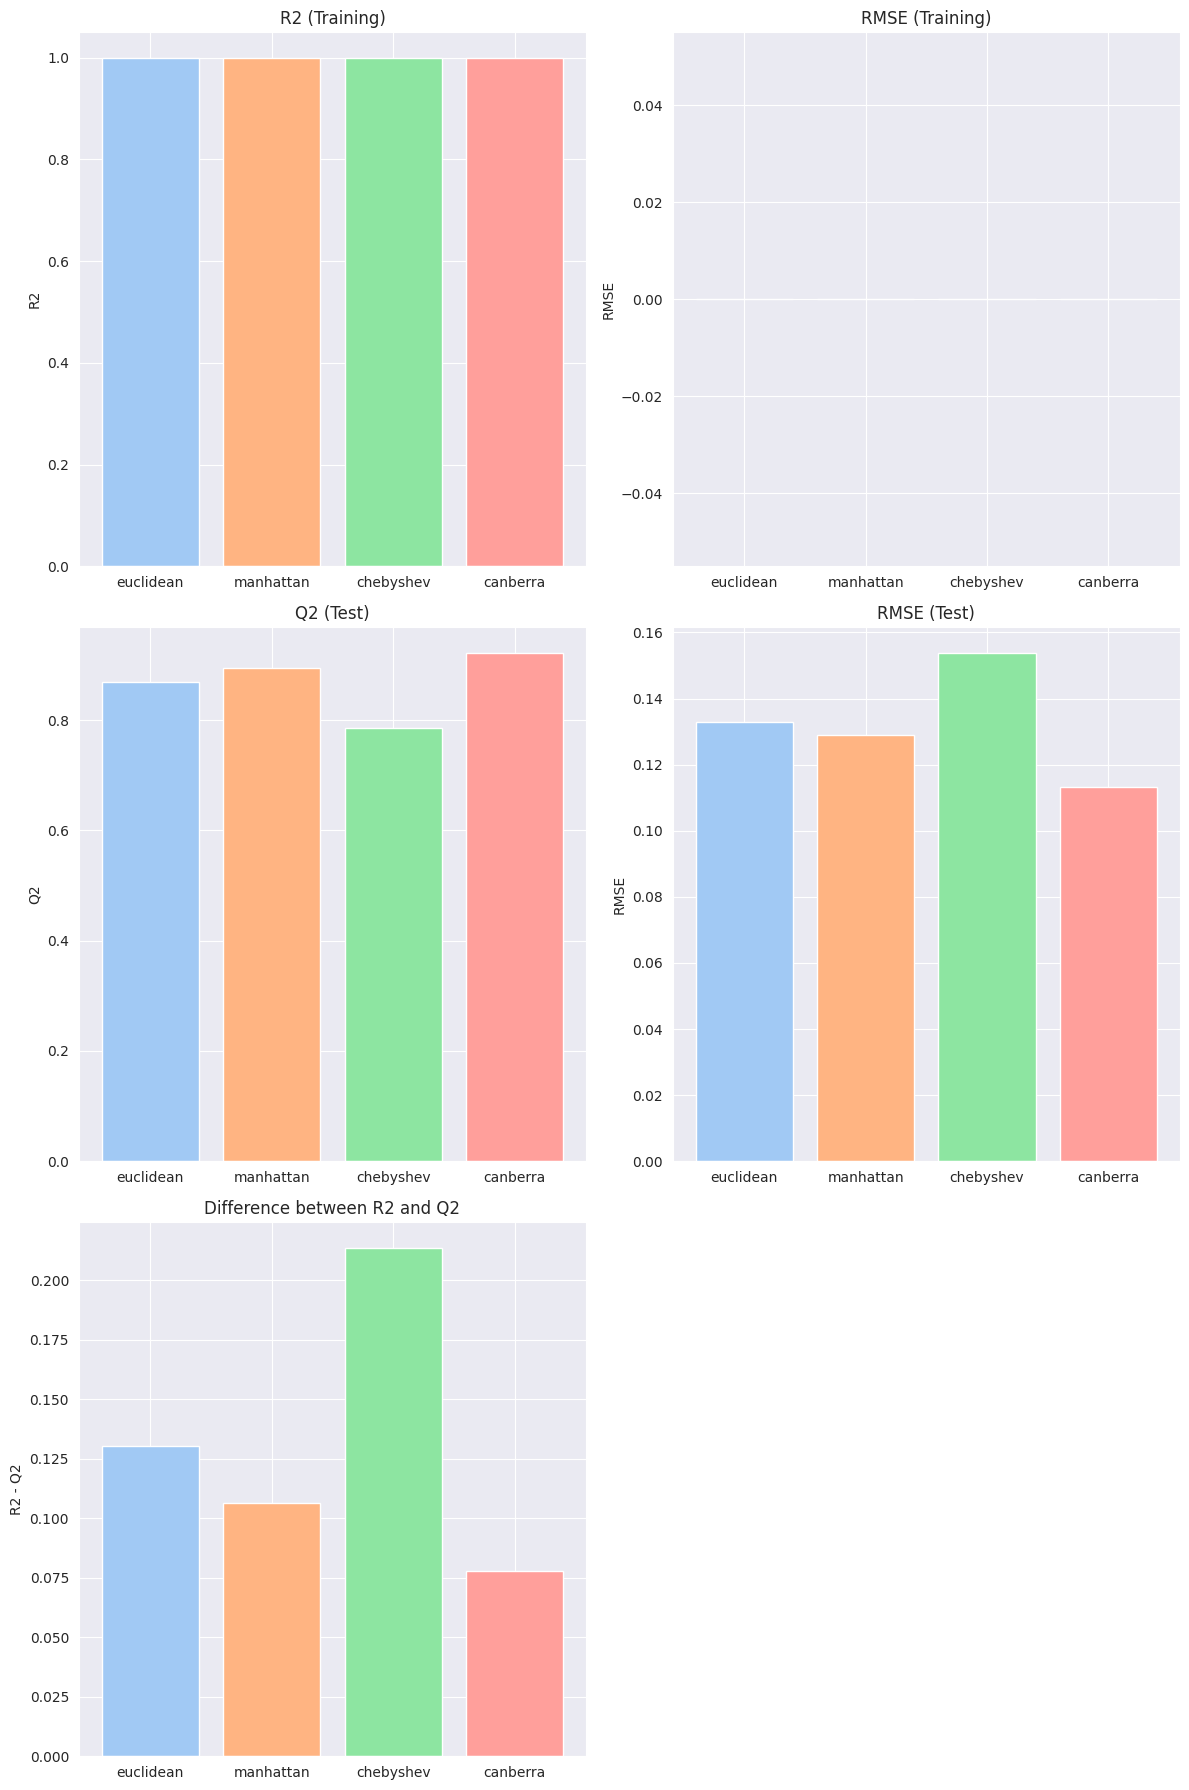

In [26]:
KNN_model_metrics_comparision(True)

Biorąc pod uwagę statystyki $RMSE_c$, $R^2$, $RMSE_{ext}$ i $Q^2$ można stwierdzić, że metoda $KNN$ bardzo dobrze sobie poradziła ze względu na wysokie wartości $R^2$ i $Q^2$ oraz niskie wartości $RMSE_c$ i $RMSE_{ext}$. Rozkład korzystności użycia modeli względem użytej metryki odległości wygląda następująco:

Canberra > Manhattan > Euclidean > Chebyshev

Użycie metody $weighted \ KNN$ powoduje otrzymanie przeuczonych modeli. Dzieję się tak niezależnie od użytej metryki odległości. Wiemy to ze względu na wartość $R^2 = 1$. 

Wyjaśnienie statystyk:
- $R^2 \ [0,1]$  wyznacza jakość nauczenia się modelu obiektów ze zbioru treningowego. Wyższa wartość oznacza lepsze dopasowanie.
- $RMSE_c \ [0, \infty]$ wyznacza pierwiastek z sumy średnich różnic pomiędzy predykcjami oraz obserwacjami dla zbioru treningowego. Im mniejsza wartość tym lepiej.
- $Q^2 \ [0,1]$  wyznacza jakość nauczenia się modelu obiektów ze zbioru testowego. Wyższa wartość oznacza lepsze dopasowanie.
- $RMSE_{ext} \ [0, \infty]$ wyznacza pierwiastek z sumy średnich różnic pomiędzy predykcjami oraz obserwacjami dla zbioru testowego. Im mniejsza wartość tym lepiej.

Normalnie, metoda $weighted \ KNN$ powinna być lepsza. W tym przypadku operujemy na małym zbiorze danych, co powoduje przeuczenie się modelu. Dlatego warto tworzyć oba typy modeli i je porównywać aby nie wpaść w pułapkę używania $weighted \ KNN$ tylko dlatego, że $\it{powinien}$ być lepszy.